# $$\text{Trajectory Prediction System}$$
---
<p style = "text-align:right"><i>by: Shreeyansh Das</i></p>

The GPS trajectory dataset was collected in (Microsoft Research Asia) GeoLife project by 182 users in a period of over three years (from April 2007 to August 2012). A GPS trajectory of this dataset is represented by a sequence of time-stamped points, each of which contains the information of latitude, longitude and altitude. This dataset contains __17,621 trajectories__ with a total distance of about __1.2 million kilometers__ and a total duration of __48,000+ hours__. These trajectories were recorded by different GPS loggers and GPS-phones, and have a variety of sampling rates. $ 91\text{%} $ of the trajectories are logged in a dense representation, e.g. every 1-5 seconds or every 5~10 meters per point.

This dataset recoded a broad range of users’ outdoor movements, including not only life routines like go home and go to work but also some entertainments and sports activities, such as shopping, sightseeing, dining, hiking, and cycling. This trajectory dataset can be used in many research fields, such as mobility pattern mining, user activity recognition, location-based social networks, location privacy, and location recommendation.

## $\text{0. Dataset Description}$

The top level Data/ folder contains 182 user folders, numbered 000/ to 181/. Each user folder has a Trajectory/ folder containing the user’s GPS trajectories (saved as .plt files) and optionally a labels.txt file specifying the mode of transportation employed for a given time interval.

The .plt files look like this. Starting with the seventh line, each line specifies in a comma-separated fashion the attributes of a single GPS point: 

__(0) latitude, (1) longitude, (2) unused, (3) altitude, (4) days since Dec. 30 1899, (5) date, (6) time.__

Every single folder of this dataset stores a user’s GPS log files, which were converted to PLT format. Each PLT file contains a single trajectory and is named by its starting time. To avoid potential confusion of time zone, we use GMT in the date/time property of each point, which is different from our previous release.

__PLT format__:

Line 1…6 are useless in this dataset, and can be ignored. Points are described in following lines, one for each line.

- Field 1: Latitude in decimal degrees.

- Field 2: Longitude in decimal degrees.

- Field 3: All set to 0 for this dataset.

- Field 4: Altitude in feet (-777 if not valid).

- Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.

- Field 6: Date as a string.

- Field 7: Time as a string.

Note that field 5 and field 6&7 represent the same date/time in this dataset. You may use either of them.

__Example__:

39.906631,116.385564,0,492,40097.5864583333,2009-10-11,14:04:30

39.906554,116.385625,0,492,40097.5865162037,2009-10-11,14:04:35

__Transportation Mode Labels__:

Possible transportation modes are: __walk, bike, bus, car, subway, train, airplane, boat, run and motorcycle__. Again, we have converted the date/time of all labels to GMT, even though most of them were created in China.

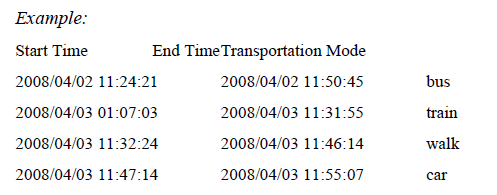

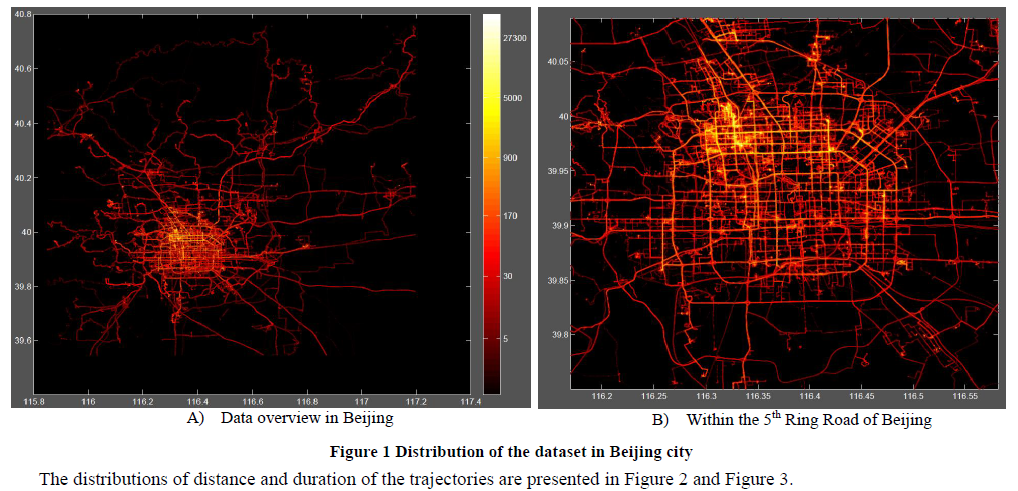

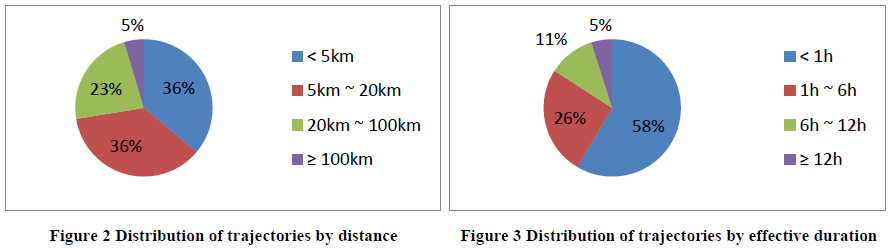

## $\text{1. Dataset Loading}$

Both `.plt` and `labels.txt` files are readily parsed using `pandas.read_csv()`, which also has builtin date/time parsing capabilities. The following code defines Python functions that use `pandas.read_csv()` to load the Geolife dataset into Python.

In [1]:
import numpy as np
import pandas as pd
import glob
import os.path
import os

from itertools import groupby
from operator import itemgetter

from operator import mul
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from haversine import haversine
from datetime import datetime
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def read_plt(plt_file):
    points = pd.read_csv(plt_file, skiprows=6, header=None,
                         parse_dates=[[5, 6]], infer_datetime_format=True)

    # for clarity rename columns
    points.rename(inplace=True, columns={'5_6': 'time', 0: 'lat', 1: 'lon', 3: 'alt'})

    # remove unused columns
    points.drop(inplace=True, columns=[2, 4])

    return points

mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}

def read_labels(labels_file):
    labels = pd.read_csv(labels_file, skiprows=1, header=None,
                         parse_dates=[[0, 1], [2, 3]],
                         infer_datetime_format=True, delim_whitespace=True)

    # for clarity rename columns
    labels.columns = ['start_time', 'end_time', 'label']

    # replace 'label' column with integer encoding
    labels['label'] = [mode_ids[i] for i in labels['label']]

    return labels

def apply_labels(points, labels):
    indices = labels['start_time'].searchsorted(points['time'], side='right') - 1
    no_label = (indices < 0) | (points['time'].values >= labels['end_time'].iloc[indices].values)
    points['label'] = labels['label'].iloc[indices].values
    points['label'][no_label] = 0

def read_user(user_folder):
    labels = None

    plt_files = glob.glob(os.path.join(user_folder, 'Trajectory', '*.plt'))
    df = pd.concat([read_plt(f) for f in plt_files])

    labels_file = os.path.join(user_folder, 'labels.txt')
    if os.path.exists(labels_file):
        labels = read_labels(labels_file)
        apply_labels(df, labels)
    else:
        df['label'] = 0

    return df

def read_all_users(folder):
    subfolders = os.listdir(folder)
    dfs = []
    for i, sf in enumerate(subfolders):
        print('[%d/%d] processing user %s' % (i + 1, len(subfolders), sf))
        df = read_user(os.path.join(folder,sf))
        df['user'] = int(sf)
        dfs.append(df)
    return pd.concat(dfs)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# df = read_all_users('Data')

Export to `csv` for faster future use

In [5]:
# df.to_csv("C:/Users/asus/Desktop/Trajectory Prediction/trajectories.csv", index = False)

In [6]:
df = pd.read_csv('geolife_raw.csv')

In [7]:
df.shape

(4485796, 5)

In [8]:
df.head()

,t_user_id,collected_time,latitude,longitude,transportation_mode
0,10,2008-08-01 04:25:10-03,40.039448,116.598225,subway
1,10,2008-08-01 04:25:11-03,40.039601,116.598183,subway
2,10,2008-08-01 04:25:12-03,40.039759,116.598149,subway
3,10,2008-08-01 04:25:13-03,40.039911,116.598111,subway
4,10,2008-08-01 04:25:14-03,40.040061,116.598083,subway


In [9]:
df['transportation_mode'].value_counts()

walk          1596330
bus           1275667
train          556318
car            506035
subway         309134
taxi           240046
run              1928
motorcycle        338
Name: transportation_mode, dtype: int64

The framework follows a sequence of five steps:

1. Data preparation, where GPS points are grouped in trajectory samples
2. Point features generation
3. Trajectory features extraction
4. Model Building
5. Classification Algorithm Validation

## $\text{2. Data Pre-processing}$

Sorting data in ascending order of `t_user_id` and `collected_time`. This way of sorting the data is equivalent to grouping the data on the bases of `t_user_id` and `collected_time`.

In [10]:
df = df.sort_values(['t_user_id', 'collected_time'], ascending=True).reset_index(drop=True)
total = len(df)

The preprocessing below has created a DataFrame with the columns arranged in a much more better computational way.
Columns of processable data now are :- 

`t_user_id`, `transportation_mode`, `date_Start`, `time_Start`, `latitude_Start`, `longitude_Start`,
`latitude_End`, `longitude_End`,`date_End`, `time_End`, `UserChk`, `ModeChk`

In [11]:
# x = df['collected_time'].str.split(' ', expand = True)
# df['date_Start'] = x[0]
# y = x[1].str.split('-', expand = True)
# df['time_Start'] = y[0]
# df['latitude_Start'] = df['latitude']
# df['longitude_Start'] = df['longitude']

# df['latitude_End'] = df['latitude'].drop([0]).reset_index(drop=True)
# df['longitude_End'] = df['longitude'].drop([0]).reset_index(drop=True)

# df['date_End'] = df['date_Start'].drop([0]).reset_index(drop=True)
# df['time_End'] = df['time_Start'].drop([0]).reset_index(drop=True)

# df['UserChk'] = df['t_user_id'].drop([0]).reset_index(drop=True)
# df['ModeChk'] = df['transportation_mode'].drop([0]).reset_index(drop=True)
# df = df.drop('collected_time', axis = 1)
# df = df.drop('latitude', axis = 1)
# df = df.drop('longitude', axis = 1)
# df = df.drop([total-1], axis = 0)

Export to external csv for faster future use

In [12]:
# df.to_csv("C:/Users/asus/Desktop/Trajectory Prediction/df_preproc.csv", index = False)

In [13]:
df = pd.read_csv('df_preproc.csv')

We finally convert this DataFrame to list of lists because of the better time complexity of lists than pandas DataFrame

In [14]:
dataList = df.values.tolist()

Bearing or heading angle is used to define navigation generally in the field of aircraft or marine or Vehicle navigation or while working for land surveying. 

In [15]:
def bearing_Calculator(row):
    start, end = ((row[4], row[5]), (row[6], row[7])) 
    lat1 = math.radians(float(start[0]))
    lat2 = math.radians(float(end[0]))

    diffLong = math.radians(float(end[1]) - float(start[1]))
    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)* math.cos(lat2) * math.cos(diffLong))
    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing

This below method will create this kind of list of list structure
         
         s -> (s0,s1), (s1,s2), (s2, s3), ...

In [16]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return itertools.zip_longest(a, b)

Define a plotter function to be used later

In [17]:
def plotSimilarities(dicPerType, keys, xLabels):
        count = 0
        features = [0, 1, 2, 3]
        keys = ['mean distance', 'mean speed', 'mean acceleration', 'mean bearing']
        xLabels = ['bus', 'car', 'subway', 'taxi', 'train', 'walk']
        for subset in range(4):
            plt.subplot(int(str(22) + '' + str(count + 1)))
            x = range(6)
            print(dicPerType['bus'][subset], dicPerType['car'][subset], dicPerType['subway'][subset],
                  dicPerType['taxi'][subset], dicPerType['train'][subset], dicPerType['walk'][subset])
            width = 1 / 1.5
            plt.bar(x, list([dicPerType['bus'][subset], dicPerType['car'][subset], dicPerType['subway'][subset],
                             dicPerType['taxi'][subset], dicPerType['train'][subset], dicPerType['walk'][subset]]),
                    width, color="blue")
            plt.xlabel('6 Classes')
            plt.ylabel(keys[count])
            plt.xticks(range(len(xLabels)), xLabels, size='small')
            plt.subplots_adjust(hspace=0.5)
            count += 1
        plt.show()

Import dependencies

In [18]:
from Utils import *
from Classifiers import *
from Evaluation import *
from scipy.stats import ttest_ind, ttest_ind_from_stats
from Plotter import *

## $\text{3. Feature Extraction}$

Here we are calculating distance, speed, acceleration and bearing. Filtering the data so as to remove as per our preprocessed data and understanding of trajectories. We are filtering:-
1. The information if starting inf is from 1 user and ending inf is from another user
2. The information if starting inf is from 1 transportation mode and ending inf is from another transportation mode
3. If the starting date and ending date match or not

In [19]:
FMT = '%H:%M:%S'
filteredData = [item for item in dataList if item[0] == item[10] and item[1] == item[11] and item[2] == item[8]]

        # Here we are creating a flag numerical column so as to easily find when there is a change in subtrajectory or trajectory
startId = filteredData[0][0]
startMode = filteredData[0][1]
startDate = filteredData[0][2]
subTrajGrper = []
count = 1
for row in filteredData:
    if (startId == row[0] and startMode == row[1] and startDate == row[2]):
        subTrajGrper.append(count)
    else:
        startId = row[0]
        startMode = row[1]
        startDate = row[2]
        count += 1
        subTrajGrper.append(count)
        
# Calculating Distance
distance = [haversine((float(row[4]), float(row[5])), (float(row[6]), float(row[7]))) * 1000.0 for row in filteredData]
        
# Calculating Time
time = [(datetime.strptime(str(row[9]), FMT) - datetime.strptime(str(row[3]), FMT)).seconds for row in filteredData]
        
# Calculating speed
speed = [x / y if y != 0 else 0 for x, y in zip(distance, time)]
        
# Calculating acceleration
pairedSpeed = list(Utils.pairwise(speed))
acceleration = [(x[1] - x[0]) / y if (y != 0 and x[1] != None) else 0 for x, y in zip(pairedSpeed, time)]
        
# Calculating Bearing
bearing = [Utils.bearing_Calculator(row) for row in filteredData]

# Here we are doing a list compression so as to add the answer of Q1 to our preprocessed data.
dataA1Soln = [u + [v, w, x, y, z] for u, v, w, x, y, z in zip(filteredData, subTrajGrper, distance, speed, acceleration, bearing)]

# Here we are masking the accleration to 0 in case it is calculated by change in speed between 2 different users.
pairedA1 = list(Utils.pairwise(dataA1Soln))
dataA1Soln = [list(map(mul, rows[0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])) if (rows[1] != None and rows[0][12] != rows[1][12]) else rows[0] for rows in pairedA1]

#dataA1Soln

In [20]:
dataA1Soln[0]

[10,
 'train',
 '2008-03-28',
 '15:12:37',
 39.728613,
 116.314788,
 39.724603,
 116.31922,
 '2008-03-28',
 '15:13:36',
 10.0,
 'train',
 1,
 585.2188568366125,
 9.918963675196823,
 -0.009101270656109463,
 139.63268887670597]

In [21]:
##### Creating sub trajectories #####
# We are filtering the data to contain only the useful columns for calculating A2 and A3
list1 = [0, 1, 2, 12, 13, 14, 15, 16]
dataImp = [[each_list[i] for i in list1] for each_list in dataA1Soln]

# Grouping the data for A2
dataSubTrajectory = [list(items) for _, items in groupby(dataImp, itemgetter(0, 1, 2, 3))]

# Filtering the subtrajectories which have points less than 10
dataFiltSubTrj = [grp for grp in dataSubTrajectory if (len(grp) > 10)]

# Calculating all the statistical values for A2. Here we calculate the
# minimum, maximum, mean and median for every subtrajectory.
A2Traj = []
count = 0
for grp in dataFiltSubTrj:
    count += 1
    statsDistance = Utils.stats_Calculator([distanceRow[4] for distanceRow in grp])
    statsSpeed = Utils.stats_Calculator([speedRow[5] for speedRow in grp])
    statsAcceleration = Utils.stats_Calculator([accRow[6] for accRow in grp])
    statsBearing = Utils.stats_Calculator([bearRow[7] for bearRow in grp])

    x1 = [grp[0][0], grp[0][1], grp[0][2], grp[0][3]]
    A2Traj.append(x1 + statsDistance + statsSpeed + statsAcceleration + statsBearing)

    # Filtering the subrajectories of motorcycle and run
    A2FiltTraj = [trj for trj in A2Traj if (trj[1] != 'motorcycle' and trj[1] != 'run')]

#A2FiltTraj

In [22]:
A2FiltTraj[0]

[10,
 'train',
 '2008-03-28',
 1,
 0.0,
 102620.86642086146,
 2634.9410558923614,
 148.52786451925945,
 13746.240819386267,
 0.0,
 32.739614374525374,
 8.261845499167599,
 2.5174214325298214,
 10.094978366043946,
 -0.21418445127164223,
 1.858631168728724,
 0.055353558675953915,
 0.0,
 0.24821982472458104,
 0.0,
 357.37077250973715,
 134.32690048073093,
 189.67934624130865,
 112.34793752881549]

Filtering the data so as to keep only those columns which will be useful for analysing the feature values by class.

18.308776351782864 66.42817676164594 32.02116057925448 25.22100693213344 338.08697659423467 10.680526171477268
5.536273251119189 8.984967633500332 10.018695218219063 8.47777879983328 26.090485542849837 1.6799976015784197
-0.05381854341651571 0.003529472598169153 -0.11674190494392231 -0.04339176358461955 -0.005723497547475878 -0.05556714538367201
177.81698832554727 186.48300934780096 206.4047590845928 178.52683351176134 185.92391747211906 176.02300490225312


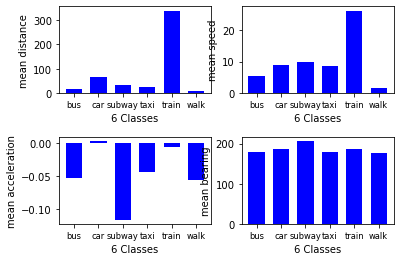

In [23]:
list2 = [0, 1, 2, 3, 6, 11, 16, 21]
A2FiltTrajF = [[each_list2[i] for i in list2] for each_list2 in A2FiltTraj]

df = pd.DataFrame(A2FiltTrajF, columns=['t_user_id', 'transportation_mode', 'date_Start', 'Flag', 'meanDis', 'meanSpeed', 'meanAcc', 'meanBrng'])

# Grouping by the mode so as to analyse the silimarities and disimilarities between classes
outgrp = df.groupby(['transportation_mode'])

# Computing the mean per class for the 4 feature values i.e distance, speed, acceleration and bearing.
dicPerType = {}
for grpType in outgrp:
    label = grpType[0]
    grp = grpType[1]
    data = []
    data.append(np.mean(grp['meanDis']))
    data.append(np.mean(grp['meanSpeed']))
    data.append(np.mean(grp['meanAcc']))
    data.append(np.mean(grp['meanBrng']))
    dicPerType[label] = data

# Plotting analysis using bar plot
count = 0
features = [0, 1, 2, 3]
keys = ['mean distance', 'mean speed', 'mean acceleration', 'mean bearing']
xLabels = ['bus', 'car', 'subway', 'taxi', 'train', 'walk']
plotSimilarities(dicPerType, keys, xLabels)

In [24]:
df.head()

,t_user_id,transportation_mode,date_Start,Flag,meanDis,meanSpeed,meanAcc,meanBrng
0,10,train,2008-03-28,1,2634.941056,8.261845,0.055354,134.326900
1,10,train,2008-03-29,2,4673.296260,16.465180,0.022802,211.016310
2,10,train,2008-03-30,3,6913.983805,8.321975,0.031994,149.693010
3,10,train,2008-03-31,4,5664.278895,16.291375,0.156839,198.146048
4,10,train,2008-04-01,5,5102.481401,13.446341,0.151271,158.416508


In [25]:
len(df)

5885

In [26]:
from sklearn.model_selection import train_test_split

In [28]:
X = df.loc[:,['meanDis','meanSpeed','meanAcc','meanBrng']]
y = df.loc[:,'transportation_mode']

In [29]:
y[:10]

0    train
1    train
2    train
3    train
4    train
5     walk
6     taxi
7      bus
8    train
9     taxi
Name: transportation_mode, dtype: object

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## $\text{4. Data Visualization}$

In [31]:
import seaborn as sns

### 4.1. Histograms

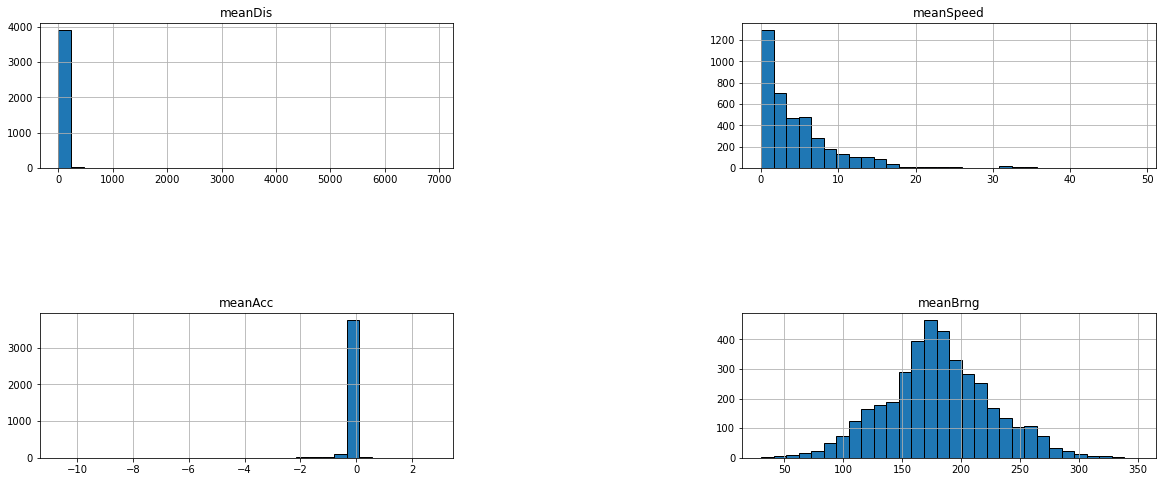

In [32]:
X_train.hist(figsize=(20, 8), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=1.0, wspace=0.7)

### 4.2. Scatterplots

In [33]:
df_temp = pd.concat([X,y], axis = 1)

In [34]:
df_temp

,meanDis,meanSpeed,meanAcc,meanBrng,transportation_mode
0,2634.941056,8.261845,0.055354,134.326900,train
1,4673.296260,16.465180,0.022802,211.016310,train
2,6913.983805,8.321975,0.031994,149.693010,train
3,5664.278895,16.291375,0.156839,198.146048,train
4,5102.481401,13.446341,0.151271,158.416508,train
...,...,...,...,...,...
5880,14.061481,7.030741,0.008454,286.410921,bus
5881,3.013852,1.494429,-0.006605,118.446660,walk
5882,19.004320,9.502160,0.002121,148.408833,bus
5883,1.974623,0.987312,-0.011146,199.641759,walk


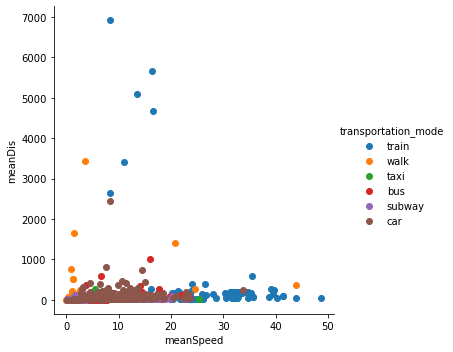

In [35]:
sns.FacetGrid(df_temp, hue = "transportation_mode", size=5) \
   .map(plt.scatter, "meanSpeed", "meanDis") \
   .add_legend()
plt.show()

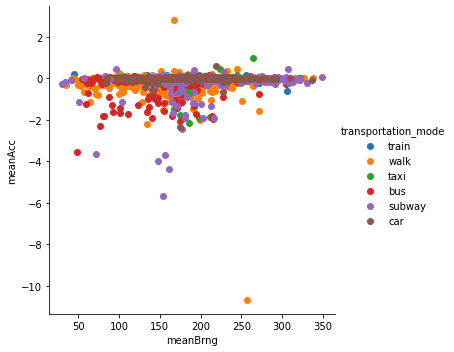

In [36]:
sns.FacetGrid(df_temp, hue = "transportation_mode", size=5) \
   .map(plt.scatter, "meanBrng", "meanAcc") \
   .add_legend()
plt.show()

### 4.3. Boxplots

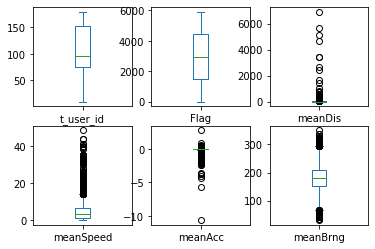

In [37]:
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

In [38]:
lst = list(df.columns)

In [39]:
lst

['t_user_id',
 'transportation_mode',
 'date_Start',
 'Flag',
 'meanDis',
 'meanSpeed',
 'meanAcc',
 'meanBrng']

In [40]:
del lst[0:4]

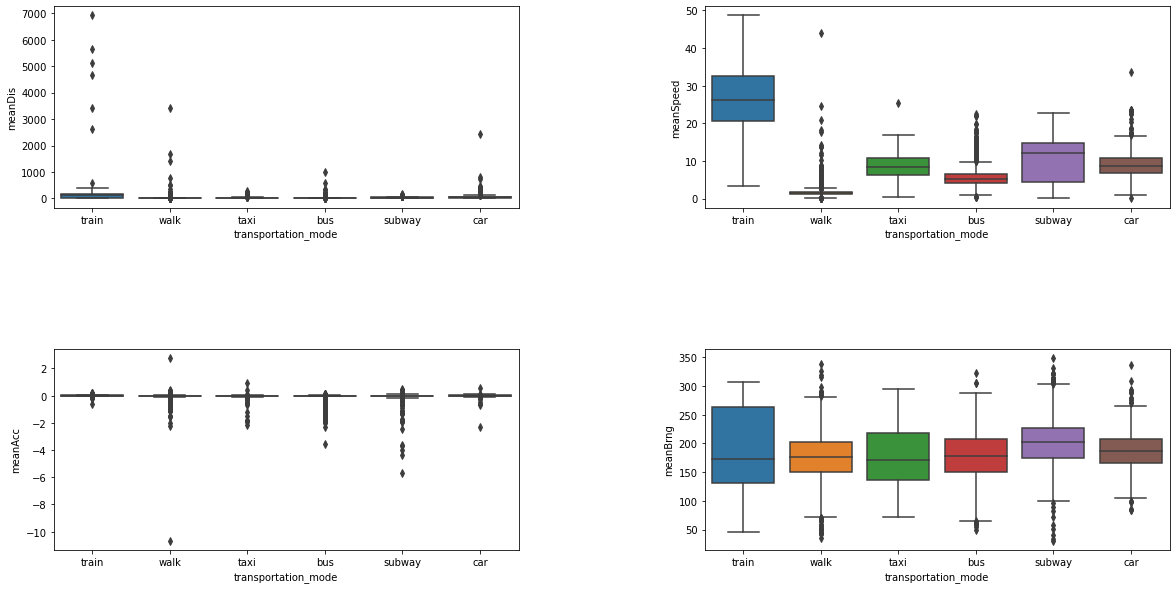

In [41]:
plt.figure(figsize = (20,10))
for i in range(len(lst)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x="transportation_mode", y=lst[i], data=df)
plt.subplots_adjust(hspace=0.7, wspace=0.4)


### 4.4. Heatmap

<AxesSubplot:>

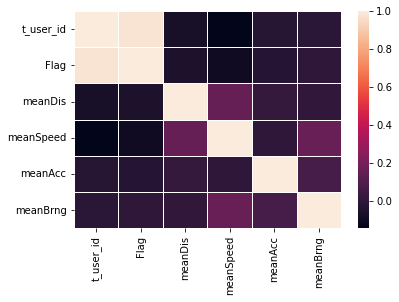

In [42]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = False, linewidth = .5)

## $\text{5. Feature Scaling}$

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

## $\text{6. Model Building}$

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

### $\text{6.1. K-Nearest Neighbor}$

In [46]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [47]:
y_test_knn = knn.predict(X_test_scaled)

### Evaluation

In [48]:
confusion_matrix(y_test, y_test_knn)

array([[394,  30,   9,  11,   0,  34],
       [ 42, 104,   8,   9,   1,  10],
       [ 22,  32,  89,   5,   0,  21],
       [ 73,  29,   7,  30,   0,   9],
       [  3,   8,   4,   1,  38,   0],
       [ 38,   2,   5,   1,   0, 874]], dtype=int64)

In [49]:
accuracy_score(y_test, y_test_knn)

0.7869274318064848

In [50]:
precision_recall_fscore_support(y_test, y_test_knn)

(array([0.68881119, 0.50731707, 0.7295082 , 0.52631579, 0.97435897,
        0.92194093]),
 array([0.82426778, 0.59770115, 0.52662722, 0.2027027 , 0.7037037 ,
        0.95      ]),
 array([0.75047619, 0.54881266, 0.61168385, 0.29268293, 0.8172043 ,
        0.93576017]),
 array([478, 174, 169, 148,  54, 920], dtype=int64))

### $\text{6.2. Support Vector Classifier}$

In [51]:
svc = LinearSVC(random_state = 0, tol = 1e-5)
svc.fit(X_train_scaled, y_train)

LinearSVC(random_state=0, tol=1e-05)

In [52]:
y_test_svc = svc.predict(X_test_scaled)

### Evaluation

In [53]:
confusion_matrix(y_test, y_test_svc)

array([[243,   5,   4,   0,   2, 224],
       [109,  34,   6,   0,   3,  22],
       [ 68,  24,  26,   0,   0,  51],
       [115,   8,   1,   0,   0,  24],
       [  9,   2,   4,   0,  38,   1],
       [  8,   1,   3,   0,   0, 908]], dtype=int64)

In [54]:
accuracy_score(y_test, y_test_svc)

0.6428203808543489

In [55]:
precision_recall_fscore_support(y_test, y_test_svc)

(array([0.44021739, 0.45945946, 0.59090909, 0.        , 0.88372093,
        0.73821138]),
 array([0.5083682 , 0.1954023 , 0.15384615, 0.        , 0.7037037 ,
        0.98695652]),
 array([0.47184466, 0.27419355, 0.24413146, 0.        , 0.78350515,
        0.84465116]),
 array([478, 174, 169, 148,  54, 920], dtype=int64))

### $\text{6.3. Decision Tree}$

In [56]:
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=0)

In [57]:
y_test_dtc = dtc.predict(X_test_scaled)

### Evaluation

In [58]:
confusion_matrix(y_test, y_test_dtc)

array([[236,  59,  50,  68,   3,  62],
       [ 24,  42,  80,  14,   1,  13],
       [ 16,  16,  70,  34,   5,  28],
       [ 37,  31,  21,  44,   1,  14],
       [  2,  30,   3,   1,  13,   5],
       [ 24,   3,  19,  55,   0, 819]], dtype=int64)

In [59]:
accuracy_score(y_test, y_test_dtc)

0.6299536798764797

In [60]:
precision_recall_fscore_support(y_test, y_test_dtc)

(array([0.69616519, 0.2320442 , 0.28806584, 0.2037037 , 0.56521739,
        0.87035069]),
 array([0.49372385, 0.24137931, 0.41420118, 0.2972973 , 0.24074074,
        0.89021739]),
 array([0.57772338, 0.23661972, 0.33980583, 0.24175824, 0.33766234,
        0.88017195]),
 array([478, 174, 169, 148,  54, 920], dtype=int64))

### $\text{6.4. OneVsRest Classifier (Logistic for Multiclass)}$

In [61]:
clf = LogisticRegression(random_state = 0)
ovr = OneVsRestClassifier(clf)

In [62]:
ovr.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=0))

In [63]:
y_test_clf = ovr.predict(X_test_scaled)

### Evaluation

In [64]:
confusion_matrix(y_test, y_test_dtc)

array([[236,  59,  50,  68,   3,  62],
       [ 24,  42,  80,  14,   1,  13],
       [ 16,  16,  70,  34,   5,  28],
       [ 37,  31,  21,  44,   1,  14],
       [  2,  30,   3,   1,  13,   5],
       [ 24,   3,  19,  55,   0, 819]], dtype=int64)

In [65]:
accuracy_score(y_test, y_test_clf)

0.6803911477097272

In [66]:
precision_recall_fscore_support(y_test, y_test_clf)

(array([0.49283668, 0.38333333, 0.51020408, 0.        , 0.89189189,
        0.81619654]),
 array([0.71966527, 0.13218391, 0.14792899, 0.        , 0.61111111,
        0.975     ]),
 array([0.58503401, 0.1965812 , 0.2293578 , 0.        , 0.72527473,
        0.88855869]),
 array([478, 174, 169, 148,  54, 920], dtype=int64))

### $\text{6.5. Random Forest Classifier}$

In [67]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [68]:
y_test_rfc = rfc.predict(X_test_scaled)

### Evaluation

In [69]:
confusion_matrix(y_test, y_test_rfc)

array([[395,  41,   0,   0,   0,  42],
       [ 50, 115,   0,   0,   0,   9],
       [111,  31,   0,   0,   0,  27],
       [105,  28,   0,   0,   0,  15],
       [ 21,  33,   0,   0,   0,   0],
       [ 48,   2,   0,   0,   0, 870]], dtype=int64)

In [70]:
accuracy_score(y_test, y_test_rfc)

0.7102418939783839

In [71]:
precision_recall_fscore_support(y_test, y_test_rfc)

(array([0.54109589, 0.46      , 0.        , 0.        , 0.        ,
        0.90342679]),
 array([0.82635983, 0.66091954, 0.        , 0.        , 0.        ,
        0.94565217]),
 array([0.65397351, 0.54245283, 0.        , 0.        , 0.        ,
        0.92405736]),
 array([478, 174, 169, 148,  54, 920], dtype=int64))

## $\text{7. Evaluation}$

Best Model performances so far in decreasing order as per their accuracy are: 

- $\text{K-Nearest Neighbor: 0.78 - K-Nearest Neighbor showed best performance for 5 neighbors}$
- $\text{Random Forest Classifier: 0.71 - Random Forest Classifier was trained for a max_depth of 2 to avoid overfitting}$
- $\text{One Vs. Rest: 0.68 - For the One Vs. Rest Classifier logistic regression was chosen as a kernel}$
- $\text{Support Vector Classifier: 0.64 - For support vector classifier the tolerance was taken to be 10e-5 as a stopping criterion}$
- $\text{Decison Tree: 0.62 - For decision tree the no. of iterations was set to default (10) to avoid overfitting}$
